In [1]:
import time

import gym
import gym_snake
from ml_tools import q_learning

import numpy as np
import matplotlib.pyplot as plt

from ml_tools.ui import UI

ui = UI()
ui.connect("./public")

'127.0.0.1:50433'

In [2]:
# brain_name = "baseline"
brain_name = "pre-trained/baseline"
# brain_name = "pre-trained/all-trainable"

load_pre_trained = True

In [3]:
from brain.v4.brain import Brain
from preprocessor.v1.preprocessor import Preprocessor

preprocessor = Preprocessor()
preprocessor.ui = ui
brain = Brain(learning_rate=0.0001)
brain.ui = ui

if load_pre_trained:
  pre_trained_name = "pre-trained"
  pre_trained_model_name = "@@_model_pre-trained"
  
  brain.load_layers_and_compile_model(
    name=pre_trained_name, model_name=pre_trained_model_name, 
    num_layers=6, trainable=False
  )
  print("")
else:
  brain.build_and_compile_model()

brain.model.summary()

Loaded layer:
input_1
conv2d
max_pooling2d
conv2d_1
max_pooling2d_1
flatten

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 11, 11, 32)        6176      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 6, 6, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 64)          32832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 2, 64)         0         
 2D)                                                             
                                                  

In [4]:
agent = q_learning.Agent(
  action_space=[0, 1, 2, 3],

  brain=brain, preprocessor=preprocessor,

  epsilon_start = 1,
  epsilon_stop = 0.001,
  epsilon_decay_num_steps = 1_000,
  
  discount_factor=0.97,
  
  replay_batch_size=32*2,
  model_batch_size=16,

  steps_to_train=20,
  steps_to_update_target=40,

  replay_memory_max_len=50_000,
  replay_memory_min_len= 2_000,
)

env = gym.make("snake-v0")

score = 0
scores = []
epsilons = []

game_num = 0

In [ ]:
raw_observation = env.reset()
agent.reset(raw_observation)

while True:
  if game_num == 5_000:
    break
    
  ui.video.update_stream("raw", raw_observation)

  speed = int(ui.control.get_value("speed") or 100)
  if speed != 100:
    time.sleep(1 / speed)

  agent.training = True if (ui.control.get_value("training") or "true") == "true" else False
  action = agent.act()
  raw_next_observation, reward, done, info = env.step(action)
  agent.step(reward, raw_next_observation)
  score += reward

  raw_observation = raw_next_observation
  if done:
    scores.append(score)
    epsilons.append(agent.epsilon)
    score = 0

    game_num += 1

    raw_observation = env.reset()
    agent.reset(raw_observation)

2022-04-19 19:23:41.482536: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


4/4 [==============================] - 0s 1ms/step - loss: 0.0150


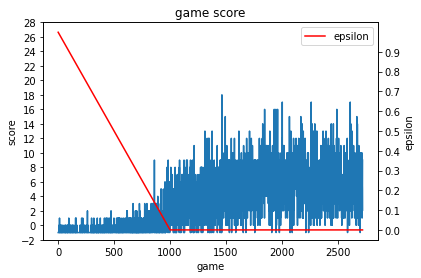

In [8]:
_, ax1 = plt.subplots()

plt.title("game score")
ax1.plot(scores)
ax1.set_xlabel("game")
ax1.set_ylabel("score")
ax1.set_yticks(np.arange(-2, 30, 2))

ax2 = ax1.twinx()
ax2.plot(epsilons, "r")
ax2.set_ylabel("epsilon")
ax2.set_yticks(np.arange(0, 1, 0.1))
ax2.legend(["epsilon"], loc="upper right")

# plt.savefig(f"{brain.current_folder}/{brain_name}/game_score.jpg")
plt.show()

In [13]:
brain.save_model(name=brain_name)
agent.save_params(name=f"{brain.current_folder}/{brain_name}")

INFO:tensorflow:Assets written to: /Users/wiktorjurkiewicz/repos/00_PROJECTS/@_@_GENERAL/04_CODE/ML/snake-deep-q-learning/brain/v4/pre-trained/all-trainable/@@_model/assets
